In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
res = {'b': 6.3, 'h': 6.3, 'd': 0.28, 'alpha': 0, 'beta': 1.0}

circ_type = "fC3RC"
R = 1
C = 10

In [3]:
n = 50
m = 30 
A = np.random.randn(m, n)
b = np.random.randn(m)


x = cp.Variable(n) 
f = cp.norm(A @ x - b, p=1)
objective = cp.Minimize(f)
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)
prob.solve()

f_star = f.value

print(f.value, prob.status)

7.286302893185397 optimal


In [4]:
def prox_oracle(n, A, b, R, tilde_x):
    x = cp.Variable(n) 
    f = cp.norm(A @ x - b, p=1)
    objective = cp.Minimize(f + (1/(2*R)) * cp.sum_squares(x - tilde_x))
    constraints = [0 <= x, x <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return x.value


def subgrad_oracle(n, A, b, tilde_x):
    x = cp.Variable(n) 
    f = cp.norm(A @ x - b, p=1)
    objective = cp.Minimize(f)
    constraints = [x == tilde_x, 0 <= x, x <= 1]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    return -constraints[0].dual_value

In [5]:
for _ in range(20):
    x1 = np.random.rand(n)
    f_x1 = np.linalg.norm(A @ x1 - b, ord=1)
    g_x1 = subgrad_oracle(n, A, b, x1)

    x2 = prox_oracle(n, A, b, R, x1)
    g_x2 = (1/R) * (x1 - x2)
    f_x2 = np.linalg.norm(A @ x2 - b, ord=1)
    for _ in range(50):
        y = np.random.rand(n)
        f_y = np.linalg.norm(A @ y - b, ord=1)
        assert f_x1 + g_x1.T @ (y - x1) - 1e-6 <= f_y
        assert f_x2 + g_x2.T @ (y - x2) - 1e-6 <= f_y

print("PASSED subgradient test")

PASSED subgradient test


# Algorithm from f-C-3R-C circuit

In [6]:
losses = []
z_0 = np.zeros(n)
e2_0 = np.zeros(n)
for k in range(100):
    x1 = prox_oracle(n, A, b, R/2, z_0)
    g_x1 = (2 / R) * (z_0 - x1)
    e2_1 = e2_0 - res["h"] / (2 * R * C) * (R * g_x1 + 3 * e2_0)
    z_1 = z_0 - res["h"] / (4 * R * C) * (5 * R * g_x1 + 3 * e2_0)
    losses += [np.linalg.norm(A @ x1 - b, ord=1)]
    e2_0 = e2_1
    z_0 = z_1

print(f"{losses[-1]=}, {f_star=}")

losses[-1]=7.286302891180717, f_star=7.286302893185397


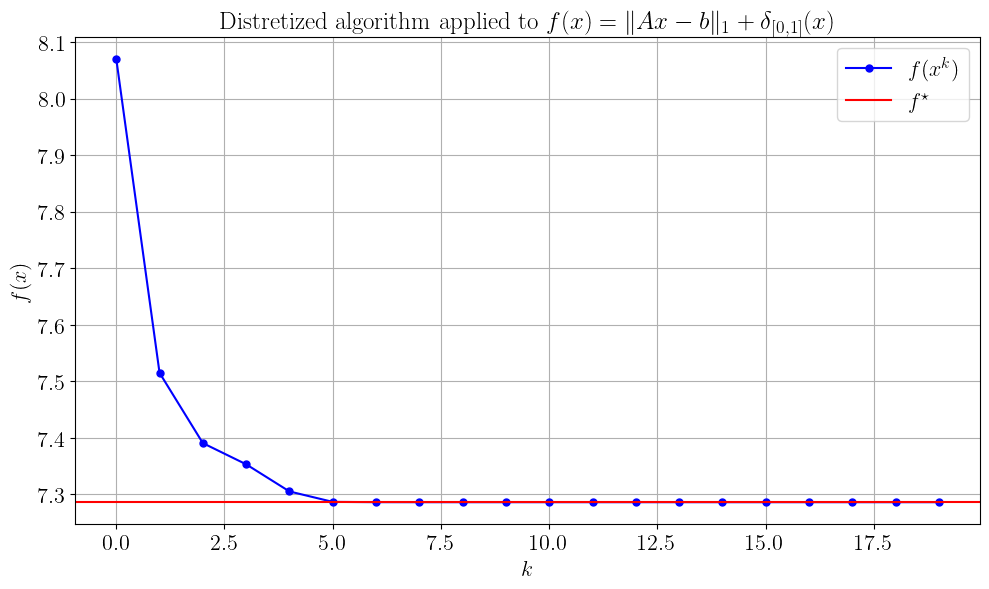

In [7]:
plt.figure(figsize=(10, 6))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(losses[:20], label=r'$f(x^k)$', color='blue', marker='o', ms=5)
plt.axhline(y=f_star, color='red', linestyle='-', label=r"$f^\star$") 

plt.title(r'Distretized algorithm applied to $f(x)=\|Ax-b\|_1 + \delta_{[0, 1]}(x)$', fontsize=18, fontname='serif')
plt.xlabel(r'$k$', fontsize=16)
plt.ylabel(r"$f(x)$", fontsize=16)
plt.legend(fontsize=16) 
plt.xticks(fontsize=16, fontname='serif')
plt.yticks(fontsize=16, fontname='serif')
plt.legend(fontsize=16) 
plt.grid(True)
plt.tight_layout()
plt.savefig(f'plots/simple_optimization_via_{circ_type}.pdf')
plt.show()